In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from nb_001b import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math, random, collections, torch
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch import tensor, Tensor, FloatTensor, LongTensor, ByteTensor, DoubleTensor, HalfTensor, ShortTensor
from operator import itemgetter, attrgetter
from numpy import cos, sin, tan, tanh, log, exp
from dataclasses import field

from functools import reduce
from collections import defaultdict, abc, namedtuple, Iterable

# CIFAR subset data

First we want to view our data to check if everything is how we expect it to be.

## Setup

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

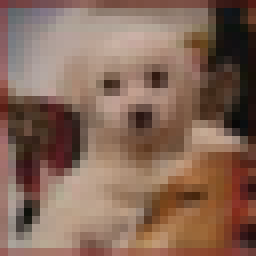

In [4]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = PIL.Image.open(dog_fn)
dog_image.resize((256,256))

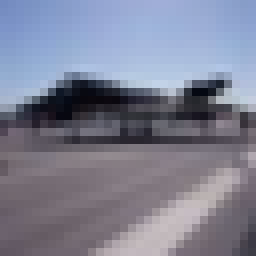

In [5]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[1]
air_image = PIL.Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

We will build a Dataset class for our image files. A Dataset class needs to have two functions: length and get-item. Our FilesDataset additionally gets the image files from their respective directories and transforms them to tensors.

In [6]:
#export
def find_classes(folder):
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

def get_image_files(c):
    return [o for o in list(c.iterdir())
            if not o.name.startswith('.') and not o.is_dir()]

def pil2tensor(image):
    arr = torch.ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1)
    arr = arr.permute(2,0,1)
    return arr.float().div_(255)

def open_image(fn):
    x = PIL.Image.open(fn).convert('RGB')
    return pil2tensor(x)

In [7]:
#export
class FilesDataset(Dataset):
    def __init__(self, folder, classes=None):
        self.fns, self.y = [], []
        if classes is None: classes = [cls.name for cls in find_classes(folder)]
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)
    def __getitem__(self,i): return open_image(self.fns[i]),self.y[i]

In [8]:
train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test')

In [9]:
len(train_ds), len(valid_ds)

(10000, 2000)

In [10]:
#export
def image2np(image): return image.cpu().permute(1,2,0).numpy()

airplane


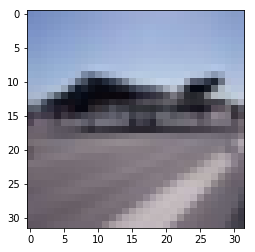

In [11]:
x,y = train_ds[1]
plt.imshow(image2np(x))
print(train_ds.classes[y])

In [12]:
bs=64

In [13]:
data = DataBunch(train_ds, valid_ds, bs=bs)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [14]:
#export
def show_image(img, ax=None, figsize=(3,3), hide_axis=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img))
    if hide_axis: ax.axis('off')

def show_image_batch(dl, classes, rows=None, figsize=(12,15)):
    x,y = next(iter(dl))
    if rows is None: rows = int(math.sqrt(len(x)))
    show_images(x[:rows*rows],y[:rows*rows],rows, classes)

def show_images(x,y,rows, classes, figsize=(9,9)):
    fig, axs = plt.subplots(rows,rows,figsize=figsize)
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

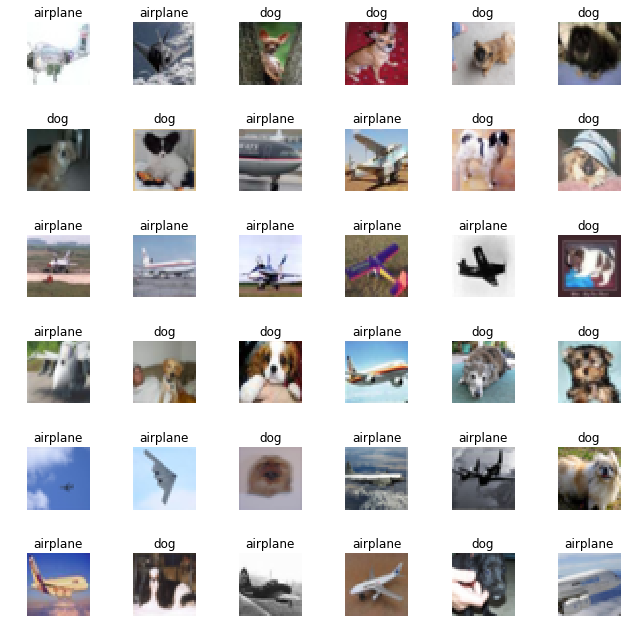

In [15]:
show_image_batch(data.train_dl, train_ds.classes, 6)

# Data augmentation

We are going augment our data to increase our training set with artificial images. These new images are basically "free" data that we can use in our training to help our model generalize better (reduce overfitting).

## Lighting

We will start by changing the **brightness** and **contrast** of our images.

### Method

**Brightness**

Brightness refers to where does our image stand on the dark-light spectrum. Brightness is applied by adding a positive constant to each of the image's channels. This works because each of the channels in an image goes from 0 (darkest) to 255 (brightest) in a dark-light continum. (0, 0, 0) is black (total abscence of light) and (255, 255, 255) is white (pure light). You can check how this works by experimenting by yourself [here](https://www.w3schools.com/colors/colors_rgb.asp).

_Parameters_

1. **Change** How much brightness do we want to add to (or take from) the image.

    Domain: Real numbers
    
**Contrast**

Contrast refers to how sharp a distinction there is between brighter and darker sections of our image. To increase contrast we need darker pixels to be darker and lighter pixels to be lighter. In other words, we would like channels with a value smaller than 128 to decrease and channels with a value of greater than 128 to increase.

_Parameters_

1. **Scale** How much contrast do we want to add to (or remove from) the image.

    Domain: [0, +inf]
    
***On logit and sigmoid***

Notice that for both transformations we first apply the logit to our tensor, then apply the transformation and finally take the sigmoid. This is important for two reasons. 

First, we don't want to overflow our tensor values. In other words, we need our final tensor values to be between [0,1].  Imagine, for instance, a tensor value at 0.99. We want to increase its brightness, but we can’t go over 1.0. By doing logit first, which first moves our space to -inf to +inf, this works fine. The same applies to contrast if we have a scale S > 1 (might make some of our tensor values greater than one).

Second, when we apply contrast, we need to affect the dispersion of values around the middle value. Say we want to increase contrast. Then we need the bright values (>0.5) to get brighter and dark values (<0.5) to get darker. We must first transform our tensor values so our values which were originally <0.5 are now negative and our values which were originally >0.5 are positive. This way, when we multiply by a constant, the dispersion around 0 will increase. The logit function does exactly this and allows us to increase or decrease dispersion around a mid value.

### Implementation

In [16]:
#export
def logit(x):  return -(1/x-1).log()
def logit_(x): return (x.reciprocal_().sub_(1)).log_().neg_()

In [17]:
def contrast(x, scale): return x.mul_(scale)

In [18]:
class Image():
    def __init__(self, px):
        self._px = px
        self._logit_px=None
    
    @property
    def px(self):
        if self._logit_px is not None:
            self._px = self._logit_px.sigmoid_()
            self._logit_px=None
        return self._px

    @property
    def logit_px(self):
        if self._logit_px is None: self._logit_px = logit_(self.px)
        return self._logit_px
    @logit_px.setter
    def logit_px(self,v): self._logit_px=v
    
    def show(self, ax=None, **kwargs):
        show_image(self.px, ax=ax, **kwargs)
        
    def lighting(self, func, *args, **kwargs):
        self.logit_px = func(self.logit_px, *args, **kwargs)
        return self
        
    def clone(self): return self.__class__(self.px.clone())

In [19]:
class Image():
    def __init__(self, px):
        self._px = px
        self._logit_px=None
    
    @property
    def px(self):
        if self._logit_px is not None:
            self._px = self._logit_px.sigmoid_()
            self._logit_px=None
        return self._px

    @property
    def logit_px(self):
        if self._logit_px is None: self._logit_px = logit_(self.px)
        return self._logit_px
    @logit_px.setter
    def logit_px(self,v): self._logit_px=v
    
    def show(self, ax=None, **kwargs):
        show_image(self.px, ax=ax, **kwargs)
        
    def lighting(self, func, *args, **kwargs):
        self.logit_px = func(self.logit_px, *args, **kwargs)
        return self
        
    def clone(self): return self.__class__(self.px.clone())

In [20]:
train_ds = FilesDataset(PATH/'train')
valid_ds = FilesDataset(PATH/'test')

In [21]:
x = lambda: Image(train_ds[1][0])

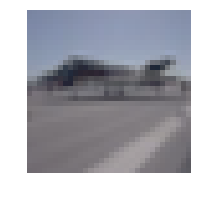

In [22]:
img = x()
img.logit_px = contrast(img.logit_px, 0.5)
img.show()

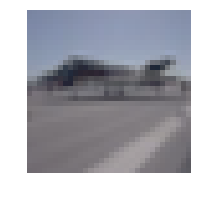

In [23]:
x().lighting(contrast, 0.5).show()

## Transform class

In [24]:
class Transform():
    _wrap=None
    def __init__(self, func): self.func=func
    def __call__(self, x, *args, **kwargs):
        if self._wrap: return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          return self.func(x, *args, **kwargs)
    
class TfmLighting(Transform): _wrap='lighting'

In [25]:
@TfmLighting
def brightness(x, change): return x.add_(scipy.special.logit(change))
@TfmLighting
def contrast(x, scale): return x.mul_(scale)

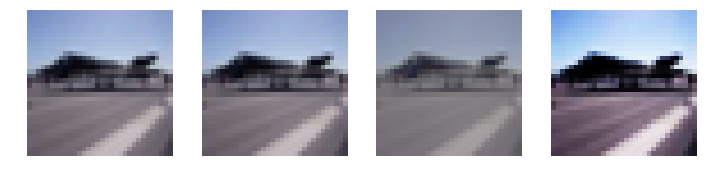

In [26]:
_,axes = plt.subplots(1,4, figsize=(12,3))

x().show(axes[0])
contrast(x(), 1.0).show(axes[1])
contrast(x(), 0.5).show(axes[2])
contrast(x(), 2.0).show(axes[3])

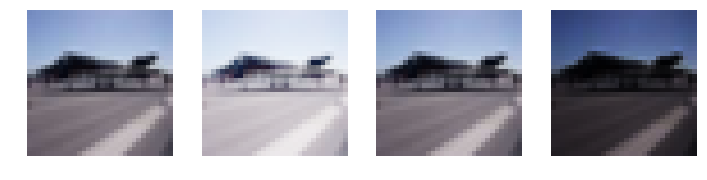

In [27]:
_,axes = plt.subplots(1,4, figsize=(12,3))

x().show(axes[0])
brightness(x(), 0.8).show(axes[1])
brightness(x(), 0.5).show(axes[2])
brightness(x(), 0.2).show(axes[3])

In [28]:
def brightness_contrast(x, scale_contrast, change_brightness):
    contrast(x, scale=scale_contrast)
    return brightness(x, change=change_brightness)

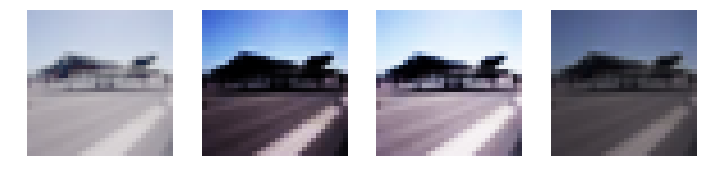

In [29]:
_,axes = plt.subplots(1,4, figsize=(12,3))

brightness_contrast(x(), 0.75, 0.7).show(axes[0])
brightness_contrast(x(), 2.0,  0.3).show(axes[1])
brightness_contrast(x(), 2.0,  0.7).show(axes[2])
brightness_contrast(x(), 0.75,  0.3).show(axes[3])

## Random lighting

Next, we will make our previous transforms random since we are interested in automatizing the pipeline. We will achieve this by making our parameters stochastic with a specific distribution. 

We will use a <a href="https://en.wikipedia.org/wiki/Uniform_distribution_(continuous)"> uniform</a> distribution for brightness change since its domain is the real numbers and the impact varies linearly with the scale. For contrast we use [log_uniform](https://www.vosesoftware.com/riskwiki/LogUniformdistribution.php) for two reasons. First, contrast scale has a domain of [0, inf]. Second, the impact of the scale in the transformation is non-linear (i.e. 0.5 is as extreme as 2.0, 0.2 is as extreme as 5). The log_uniform function is appropriate because it has the same domain and correctly represents the non-linearity of the transform, P(0.5) = P(2).

In [30]:
#export
def uniform(low, high, size=None):
    return random.uniform(low,high) if size is None else torch.FloatTensor(size).uniform_(low,high)

def log_uniform(low, high, size=None):
    res = uniform(log(low), log(high), size)
    return exp(res) if size is None else res.exp_()

def rand_bool(p, size=None): return uniform(0,1,size)<p

In [31]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

1.005514123154792

In [32]:
#export
import inspect
from copy import copy,deepcopy

def get_default_args(func):
    return {k: v.default
            for k, v in inspect.signature(func).parameters.items()
            if v.default is not inspect.Parameter.empty}

def listify(p=None, q=None):
    if p is None: p=[]
    elif not isinstance(p, Iterable): p=[p]
    n = q if type(q)==int else 1 if q is None else len(q)
    if len(p)==1: p = p * n
    return p

In [33]:
#export
class Transform():
    _wrap=None
    order=0
    def __init__(self, func, order=None):
        if order is not None: self.order=order
        self.func=func
        self.params = copy(func.__annotations__)
        self.def_args = get_default_args(func)
        
    def __call__(self, *args, p=1., **kwargs):
        if args: return self.calc(*args, **kwargs)
        else: return RandTransform(self, kwargs=kwargs, p=p)
    
    def calc(self, x, *args, **kwargs):
        if self._wrap: return getattr(x, self._wrap)(self.func, *args, **kwargs)
        else:          return self.func(x, *args, **kwargs)
        
    @property
    def name(self): return self.__class__.__name__
    
    def __repr__(self): return f'{self.name} ({self.func.__name__})'

class TfmLighting(Transform): order,_wrap = 8,'lighting'

In [34]:
#export
@dataclass
class RandTransform():
    tfm:Transform
    kwargs:dict
    p:int=1.0
    resolved:dict = field(default_factory=dict)
    do_run:bool = True
    
    def resolve(self):
        self.resolved = {}
        # for each param passed to tfm...
        for k,v in self.kwargs.items():
            # ...if it's annotated, call that fn...
            if k in self.tfm.params:
                rand_func = self.tfm.params[k]
                self.resolved[k] = rand_func(*listify(v))
            # ...otherwise use the value directly
            else: self.resolved[k] = v
        # use defaults for any args not filled in yet
        for k,v in self.tfm.def_args.items():
            if k not in self.resolved: self.resolved[k]=v

        self.do_run = rand_bool(self.p)

    @property
    def order(self): return self.tfm.order

    def __call__(self, x, *args, **kwargs):
        return self.tfm(x, *args, **{**self.resolved, **kwargs}) if self.do_run else x

In [35]:
#export
@TfmLighting
def brightness(x, change:uniform): return x.add_(scipy.special.logit(change))

@TfmLighting
def contrast(x, scale:log_uniform): return x.mul_(scale)

In [36]:
tfm = contrast(scale=(0.3,3))
tfm.resolve()
tfm,tfm.resolved,tfm.do_run

(RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.3, 3)}, p=1.0, resolved={'scale': 0.6350879179066493}, do_run=True),
 {'scale': 0.6350879179066493},
 True)

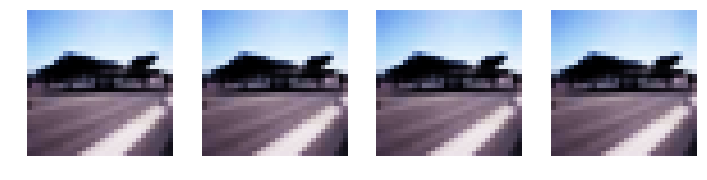

In [37]:
# all the same
tfm.resolve()

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: tfm(x()).show(ax)

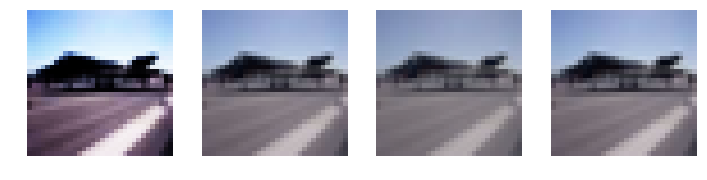

In [38]:
tfm = contrast(scale=(0.3,3), p=0.5)

# different
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    tfm(x()).show(ax)

## Composition

We are interested in composing the transform functions so as to apply them all at once. We will try to feed a list of transforms to our pipeline for it to apply all of them.

Applying a function to our transforms before calling them in Python is easiest if we use a decorator. You can find more about decorators [here](https://www.thecodeship.com/patterns/guide-to-python-function-decorators/).

In [39]:
#export
def resolve_tfms(tfms):
    for f in listify(tfms): f.resolve()

def apply_tfms(tfms, x, do_resolve=True):
    if not tfms: return x
    tfms = listify(tfms)
    if do_resolve: resolve_tfms(tfms)
    x = Image(x.clone())
    for tfm in tfms: x = tfm(x)
    return x.px

In [40]:
x = train_ds[1][0]

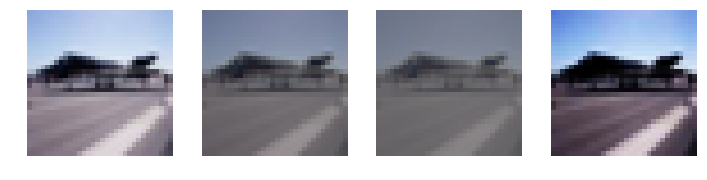

In [41]:
tfms = [contrast(scale=(0.3,3.0), p=0.9),
        brightness(change=(0.35,0.65), p=0.9)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms,x), ax)

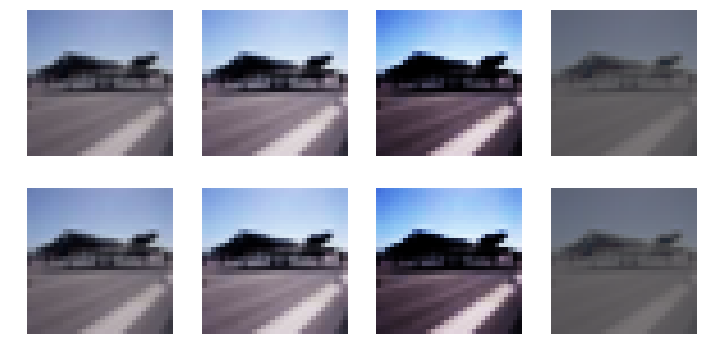

In [42]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    show_image(apply_tfms(tfms,x), axes[0,i])
    show_image(apply_tfms(tfms,x,do_resolve=False), axes[1,i])

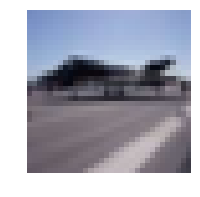

In [43]:
show_image(apply_tfms([],x))

# Affine

We will now add affine transforms that operate on the coordinates instead of pixels like the lighting transforms we just saw. An [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) is a function "(...) between affine spaces which preserves points, straight lines and planes." 

## Details

Our implementation first creates a grid of coordinates for the original image. The grid is normalized to a [-1, 1] range with (-1, -1) representing the top left corner, (1, 1) the bottom right corner and (0, 0) the center. Next, we build an affine matrix representing our desired transform and we multiply it by our original grid coordinates. The result will be a set of x, y coordinates which references where in the input image will each of the pixels in the output image be mapped. It has a size of w \* h \* 2 since it needs two coordinates for each of the h * w pixels of the output image. 

This is clearest if we see it graphically. We will build an affine matrix of the following form:

`[[a, b, e],
 [c, d, f]]`


with which we will transform each pair of x, y coordinates in our original grid into our transformation grid:


`[[a, b],       [[x],       [[e],       [[x'],
  [c, d]]   x    [y]]    +   [f]]    =   [y']]`   

So after the transform we will get a new grid with which to map our input image into our output image. This will be our **map of where from exactly does our transformation source each pixel in the output image**.

**Enter problems**

Affine transforms face two problems that must be solved independently:
1. **The interpolation problem**: The result of our transformation gives us float coordinates, and we need to decide, for each (i,j), how to assign these coordinates to pixels in the input image.
2. **The missing pixel problem**: The result of our transformation may have coordinates which exceed the [-1, 1] range of our original grid and thus fall outside of our original grid.

**Solutions to problems**

1.  **The interpolation problem**: We will perform a [bilinear interpolation](https://en.wikipedia.org/wiki/Bilinear_interpolation). This takes an average of the values of the pixels corresponding to the four points in the grid surrounding the result of our transformation, with weights depending on how close we are to each of those points. 
2. **The missing pixel problem**: For these values we need padding, and we face a few options:

    1. Adding zeros on the side (so the pixels that fall out will be black)
    2. Replacing them by the value at the border
    3. Mirroring the content of the picture on the other side (reflect padding).
    
    
### Transformation Method

**Zoom**

Zoom changes the focus of the image according to a scale. If a scale of >1 is applied, grid pixels will be mapped to coordinates that are more central than the pixel's coordinates (closer to 0,0) while if a scale of <1 is applied, grid pixels will be mapped to more perispheric coordinates (closer to the borders) in the input image.

We can also translate our transform to zoom into a non-centrical area of the image. For this we use $col_c$ which displaces the x axis and $row_c$ which displaces the y axis.

_Parameters_

1. **Scale** How much do we want to zoom in or out to our image.

    Domain:  Real numbers
        
2. **Col_pct** How much do we want to displace our zoom along the x axis.

    Domain: Real numbers between 0 and 1
    
    
3. **Row_pct** How much do we want to displace our zoom along the y axis.

    Domain: Real numbers between 0 and 1
    

<u>Affine matrix</u>

`[[1/scale, 0,       col_c],
  [0,       1/scale, row_c]]`


**Rotate**

Rotate shifts the image around its center in a given angle theta. The rotation is counterclockwise if theta is positive and clockwise if theta is negative. If you are curious about the derivation of the rotation matrix you can find it [here](https://matthew-brett.github.io/teaching/rotation_2d.html).

_Parameters_

1. **Degrees** By which angle do we want to rotate our image.

    Domain: Real numbers
        
<u>Affine matrix</u>

`[[cos(theta), -sin(theta), 0],
  [sin(theta),  cos(theta), 0]]`

## Deterministic affine

In [44]:
#export
def grid_sample_nearest(input, coords, padding_mode='zeros'):
    if padding_mode=='border': coords.clamp(-1,1)
    bs,ch,h,w = input.size()
    sz = torch.tensor([w,h]).float()[None,None]
    coords.add_(1).mul_(sz/2)
    coords = coords[0].round_().long()
    if padding_mode=='zeros':
        mask = (coords[...,0] < 0) + (coords[...,1] < 0) + (coords[...,0] >= w) + (coords[...,1] >= h)
        mask.clamp_(0,1)
    coords[...,0].clamp_(0,w-1)
    coords[...,1].clamp_(0,h-1)
    result = input[...,coords[...,1],coords[...,0]]
    if padding_mode=='zeros': result[...,mask] = result[...,mask].zero_()
    return result

In [45]:
#export
def grid_sample(x, coords, mode='bilinear', padding_mode='reflect'):
    if padding_mode=='reflect': padding_mode='reflection'
    if mode=='nearest': return grid_sample_nearest(x[None], coords, padding_mode)[0]
    return F.grid_sample(x[None], coords, mode=mode, padding_mode=padding_mode)[0]

def affine_grid(size):
    size = ((1,)+size)
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else torch.Tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else torch.Tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

def affine_mult(c,m):
    if m is None: return c
    size = c.size()
    c = c.view(-1,2)
    c = torch.addmm(m[:2,2], c,  m[:2,:2].t()) 
    return c.view(size)

In [46]:
def rotate(degrees):
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

In [47]:
c = affine_grid(x.shape)

In [48]:
m = rotate(30)
m = x.new_tensor(m)
m

tensor([[ 0.8660, -0.5000,  0.0000],
        [ 0.5000,  0.8660,  0.0000],
        [ 0.0000,  0.0000,  1.0000]])

In [49]:
c[0,...,0]

tensor([[-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        ...,
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000],
        [-1.0000, -0.9355, -0.8710,  ...,  0.8710,  0.9355,  1.0000]])

In [50]:
c[0,...,1]

tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-0.9355, -0.9355, -0.9355,  ..., -0.9355, -0.9355, -0.9355],
        [-0.8710, -0.8710, -0.8710,  ..., -0.8710, -0.8710, -0.8710],
        ...,
        [ 0.8710,  0.8710,  0.8710,  ...,  0.8710,  0.8710,  0.8710],
        [ 0.9355,  0.9355,  0.9355,  ...,  0.9355,  0.9355,  0.9355],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])

In [51]:
m

tensor([[ 0.8660, -0.5000,  0.0000],
        [ 0.5000,  0.8660,  0.0000],
        [ 0.0000,  0.0000,  1.0000]])

In [52]:
c = affine_mult(c,m)

In [53]:
c[0,...,0]

tensor([[-0.3660, -0.3102, -0.2543,  ...,  1.2543,  1.3102,  1.3660],
        [-0.3983, -0.3424, -0.2865,  ...,  1.2220,  1.2779,  1.3338],
        [-0.4305, -0.3747, -0.3188,  ...,  1.1898,  1.2456,  1.3015],
        ...,
        [-1.3015, -1.2456, -1.1898,  ...,  0.3188,  0.3747,  0.4305],
        [-1.3338, -1.2779, -1.2220,  ...,  0.2865,  0.3424,  0.3983],
        [-1.3660, -1.3102, -1.2543,  ...,  0.2543,  0.3102,  0.3660]])

In [54]:
c[0,...,1]

tensor([[-1.3660, -1.3338, -1.3015,  ..., -0.4305, -0.3983, -0.3660],
        [-1.3102, -1.2779, -1.2456,  ..., -0.3747, -0.3424, -0.3102],
        [-1.2543, -1.2220, -1.1898,  ..., -0.3188, -0.2865, -0.2543],
        ...,
        [ 0.2543,  0.2865,  0.3188,  ...,  1.1898,  1.2220,  1.2543],
        [ 0.3102,  0.3424,  0.3747,  ...,  1.2456,  1.2779,  1.3102],
        [ 0.3660,  0.3983,  0.4305,  ...,  1.3015,  1.3338,  1.3660]])

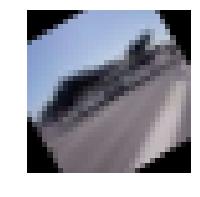

In [55]:
img2 = grid_sample(x, c, padding_mode='zeros')
show_image(img2)

In [56]:
#export
class Image():
    def __init__(self, px):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    @property
    def shape(self): return self._px.shape
    
    def __repr__(self): return f'{self.__class__.__name__} ({self.px.shape})'

    def refresh(self):
        if self._logit_px is not None:
            self._px = self._logit_px.sigmoid_()
            self._logit_px = None
        if self._affine_mat is not None or self._flow is not None:
            self._px = grid_sample(self._px, self.flow, **self.sample_kwargs)
            self.sample_kwargs = {}
            self._flow = None
        return self

    @property
    def px(self):
        self.refresh()
        return self._px
    @px.setter
    def px(self,v): self._px=v

    @property
    def flow(self):
        if self._flow is None:
            self._flow = affine_grid(self.shape)
        if self._affine_mat is not None:
            self._flow = affine_mult(self._flow,self._affine_mat)
            self._affine_mat = None
        return self._flow
    @flow.setter
    def flow(self,v): self._flow=v

    def lighting(self, func, *args, **kwargs):
        self.logit_px = func(self.logit_px, *args, **kwargs)
        return self

    def pixel(self, func, *args, **kwargs):
        self.px = func(self.px, *args, **kwargs)
        return self

    def coord(self, func, *args, **kwargs):
        self.flow = func(self.flow, self.shape, *args, **kwargs)
        return self

    def affine(self, func, *args, **kwargs):
        m = func(*args, **kwargs)
        self.affine_mat = self.affine_mat @ self._px.new(m)
        return self

    def set_sample(self, **kwargs):
        self.sample_kwargs = kwargs
        return self

    def resize(self, size):
        assert self._flow is None
        if isinstance(size, int): size=(self.shape[0], size, size)
        self.flow = affine_grid(size)
        return self

    @property
    def affine_mat(self):
        if self._affine_mat is None: self._affine_mat = self._px.new(torch.eye(3))
        return self._affine_mat
    @affine_mat.setter
    def affine_mat(self,v): self._affine_mat=v

    @property
    def logit_px(self):
        if self._logit_px is None: self._logit_px = logit_(self.px)
        return self._logit_px
    @logit_px.setter
    def logit_px(self,v): self._logit_px=v
    
    def show(self, ax=None, **kwargs): show_image(self.px, ax=ax, **kwargs)
    def clone(self): return self.__class__(self.px.clone())

In [57]:
x = train_ds[1][0]

In [58]:
def xi(): return Image(train_ds[1][0])

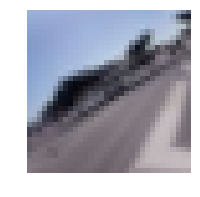

In [59]:
xi().affine(rotate, 30).show()

## Affine transform

In [60]:
#export
class TfmAffine(Transform): order,_wrap = 5,'affine'
class TfmPixel(Transform): order,_wrap = 10,'pixel'

@TfmAffine
def rotate(degrees:uniform):
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

def get_zoom_mat(sw, sh, c, r):
    return [[sw, 0,  c],
            [0, sh,  r],
            [0,  0, 1.]]

@TfmAffine
def zoom(scale:uniform=1.0, row_pct:uniform=0.5, col_pct:uniform=0.5):
    s = 1-1/scale
    col_c = s * (2*col_pct - 1)
    row_c = s * (2*row_pct - 1)
    return get_zoom_mat(1/scale, 1/scale, col_c, row_c)

@TfmAffine
def squish(scale:uniform=1.0, row_pct:uniform=0.5, col_pct:uniform=0.5):
    if scale <= 1: 
        col_c = (1-scale) * (2*col_pct - 1)
        return get_zoom_mat(scale, 1, col_c, 0.)
    else:          
        row_c = (1-1/scale) * (2*row_pct - 1)
        return get_zoom_mat(1, 1/scale, 0., row_c)

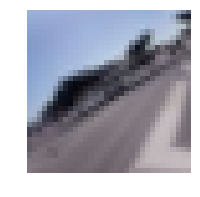

In [61]:
rotate(xi(), 30).show()

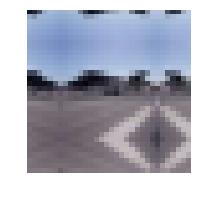

In [62]:
zoom(xi(), 0.6).show()

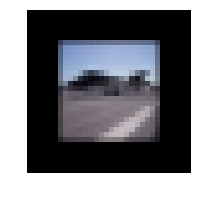

In [63]:
zoom(xi(), 0.6).set_sample(padding_mode='zeros').show()

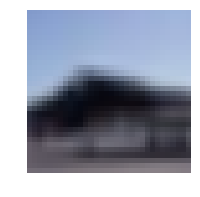

In [64]:
zoom(xi(), 2, 0.2, 0.2).show()

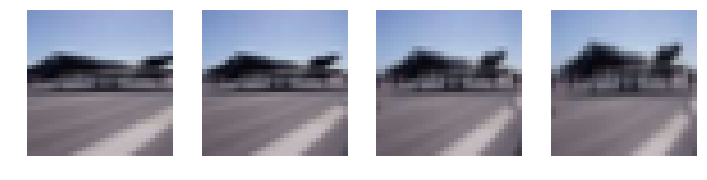

In [65]:
scales = [0.75,0.9,1.1,1.33]

_,axes = plt.subplots(1,4, figsize=(12,3))
for i, ax in enumerate(axes): squish(xi(), scales[i]).show(ax)

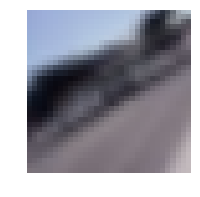

In [66]:
img2 = rotate(xi(), 30).refresh()
img2 = zoom(img2, 1.6)
img2.show()

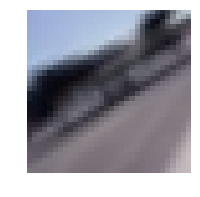

In [67]:
img2 = rotate(xi(), 30)
zoom(img2, 1.6).show()

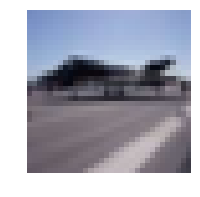

In [68]:
xi().show()

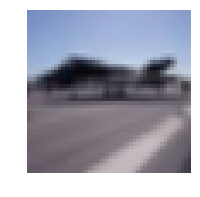

In [69]:
xi().resize(48).show()

In [70]:
#export
@partial(Transform, order=TfmAffine.order-2)
def resize_image(x, size): return x.resize(size)

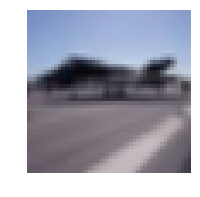

In [71]:
resize_image(xi(), 48).show()

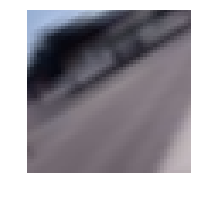

In [72]:
img2 = zoom(xi().resize(48), 1.6, 0.8, 0.2)
rotate(img2, 30).show()

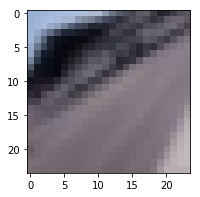

In [73]:
img2 = zoom(xi().resize(24), 1.6, 0.8, 0.2)
rotate(img2, 30).show(hide_axis=False)

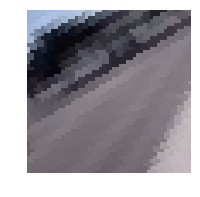

In [74]:
img2 = zoom(xi().resize(48), 1.6, 0.8, 0.2)
rotate(img2, 30).set_sample(mode='nearest').show()

## Random affine

As we did with the Lighting transform, we now want to build randomness into our pipeline so we can increase the automatization of the transform process. 

We will use a uniform distribution for both our transforms since their impact is linear and their domain is the real numbers.

**Apply all transforms**

We will make all transforms try to do as little calculations as possible.

We do only one affine transformation by multiplying all the affine matrices of the transforms, then we apply to the coords any non-affine transformation we might want (jitter, elastic distorsion). Next, we crop the coordinates we want to keep and, by doing it before the interpolation, we don't need to compute pixel values that won't be used afterwards. Finally we perform the interpolation and we apply all the transforms that operate pixelwise (brightness, contrast).

In [75]:
tfm = rotate(degrees=(-45,45.), p=0.75); tfm

RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45, 45.0)}, p=0.75, resolved={}, do_run=True)

In [76]:
tfm.resolve(); tfm

RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-45, 45.0)}, p=0.75, resolved={'degrees': -13.415007640881651}, do_run=True)

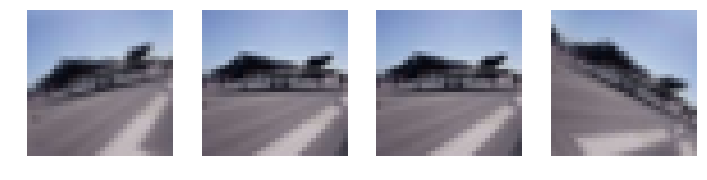

In [77]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfm, x), ax)

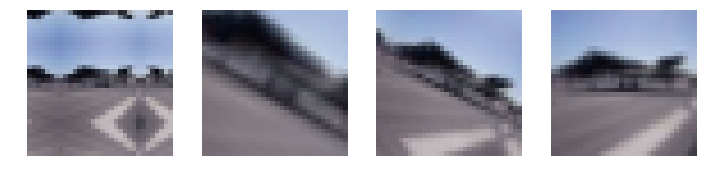

In [78]:
tfms = [rotate(degrees=(-45,45.), p=0.75),
        zoom(scale=(0.5,2.0), p=0.75)]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms,x), ax)

In [79]:
#export
def apply_tfms(tfms, x, do_resolve=True, xtra=None, size=None, **kwargs):
    if not tfms: return x
    if not xtra: xtra={}
    tfms = sorted(listify(tfms), key=lambda o: o.tfm.order)
    if do_resolve: resolve_tfms(tfms)
    x = Image(x.clone())
    if kwargs: x.set_sample(**kwargs)
    if size: x.resize(size)
    for tfm in tfms:
        if tfm.tfm in xtra: x = tfm(x, **xtra[tfm.tfm])
        else:               x = tfm(x)
    return x.px

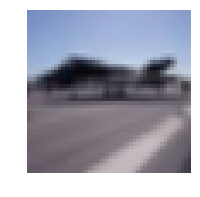

In [80]:
show_image(apply_tfms(resize_image(size=48), x))

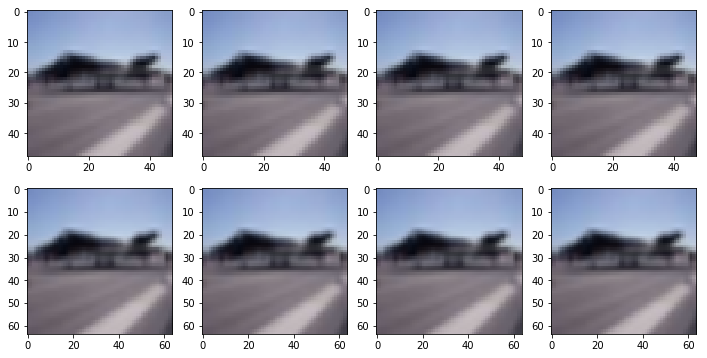

In [81]:
tfm = resize_image(size=64)
xtra = {resize_image: {'size':48}}

_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    show_image(apply_tfms(tfm, x, xtra=xtra), axes[0][i], hide_axis=False)
    show_image(apply_tfms(tfm, x, do_resolve=False), axes[1][i], hide_axis=False)

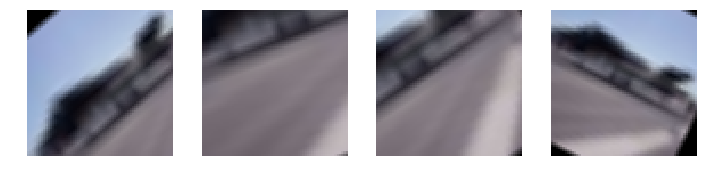

In [82]:
tfms = [rotate(degrees=(-45,45.), p=0.75),
        resize_image(size=64),
        zoom(scale=(1.0,2.0), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms,x, padding_mode='zeros'), ax)

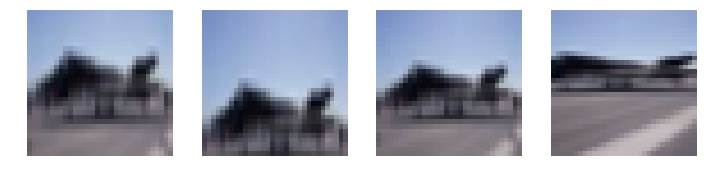

In [83]:
tfms = [squish(scale=(0.5,2), row_pct=(0,1.), col_pct=(0,1.))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms,x), ax)

# Coord and pixel

## Jitter / flip

The last two transforms we will use are **jitter** and **flip**. 

**Jitter**

Jitter is a transform which adds a random value to each of the pixels to make them somewhat different than the original ones. In our implementation we first get a random number between (-1, 1) and we multiply it by a constant M which scales it.

_Parameters_

1. **Magnitude** How much random noise do we want to add to each of the pixels in our image.

    Domain: Real numbers between 0 and 1.
    
**Flip**

Flip is a transform that reflects the image on a given axis.

_Parameters_

1. **P** Probability of applying the transformation to an input.

    Domain: Real numbers between 0 and 1.

In [84]:
#export
class TfmCoord(Transform): order,_wrap = 4,'coord'

@TfmCoord
def jitter(c, size, magnitude:uniform):
    return c.add_((torch.rand_like(c)-0.5)*magnitude*2)

@TfmPixel
def flip_lr(x): return x.flip(2)

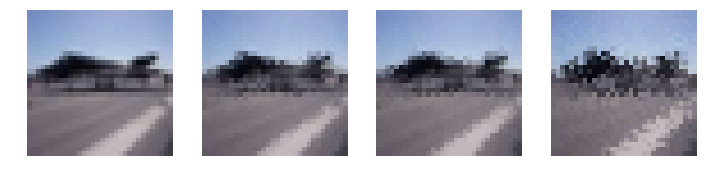

In [85]:
tfm = jitter(magnitude=(0,0.1))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    tfm(xi()).show(ax)

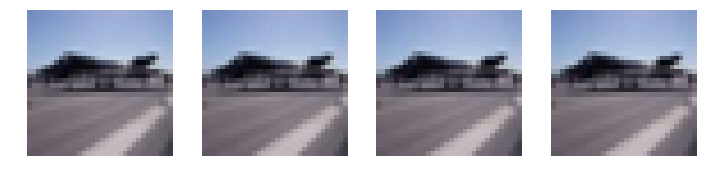

In [86]:
tfm = flip_lr(p=0.5)

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes:
    tfm.resolve()
    tfm(xi()).show(ax)

## Crop/pad

**Crop**

Crop is a transform that cuts a series of pixels from an image. It does this by removing rows and columns from the input image.

_Parameters_

1. **Size** What is the target size of each side in pixels. If only one number *s* is specified, image is made square with dimensions *s* \* *s*.

    Domain: Positive integers.
    
2. **Row_pct** Determines where to cut our image vertically on the bottom and top (which rows are left out). If <0.5, more rows will be cut in the top than in the bottom and viceversa (varies linearly).

    Domain: Real numbers between 0 and 1.
    
3. **Col_pct** Determines where to cut our image horizontally on the left and right (which columns are left out). If <0.5, more rows will be cut in the left than in the right and viceversa (varies linearly).

    Domain: Real numbers between 0 and 1.
    
Our three parameters are related with the following equations:

1. output_rows = [**row_pct***(input_rows-**size**):**size**+**row_pct***(input_rows-**size**)]

2. output_cols = [**col_pct***(input_cols-**size**):**size**+**col_pct***(input_cols-**size**)]

**Pad**


Pads each of the four borders of our image with a certain amount of pixels. Can pad with reflection (reflects border pixels to fill new pixels) or zero (adds black pixels). 

_Parameters_

1. **Padding** Amount of pixels to add to each border. [More details](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.pad)

    Domain: Positive integers.
    
2. **Mode** How to fill new pixels. For more detail see the Pytorch subfunctions for padding.

    Domain: 
    - Reflect (default): reflects opposite pixels to fill new pixels. [More details](https://pytorch.org/docs/stable/nn.html#torch.nn.ReflectionPad2d)
    - Constant: adds pixels with specified value (default is 0, black pixels) [More details](https://pytorch.org/docs/stable/nn.html#torch.nn.ConstantPad2d)
    - Replicate: replicates border row or column pixels to fill new pixels [More details](https://pytorch.org/docs/stable/nn.html#torch.nn.ReplicationPad2d)
    
    
***On using padding and crop***

A nice way to use these two functions is to combine them into one transform. We can add padding to the image and then crop some of it out. This way, we can create a new image to augment our training set without losing image information by cropping. Furthermore, this can be done in several ways (modifying the amount and type of padding and the crop style) so it gives us great flexibility to add images to our training set. You can find an example of this in the code below.

In [87]:
[(o.__name__,o.order) for o in
    sorted((Transform,TfmAffine,TfmCoord,TfmLighting,TfmPixel),key=attrgetter('order'))]

[('Transform', 0),
 ('TfmCoord', 4),
 ('TfmAffine', 5),
 ('TfmLighting', 8),
 ('TfmPixel', 10)]

In [88]:
#export
@partial(TfmPixel, order=-10)
def pad(x, padding, mode='reflect'):
    return F.pad(x[None], (padding,)*4, mode=mode)[0]

@TfmPixel
def crop(x, size, row_pct:uniform=0.5, col_pct:uniform=0.5):
    size = listify(size,2)
    rows,cols = size
    row = int((x.size(1)-rows+1) * row_pct)
    col = int((x.size(2)-cols+1) * col_pct)
    return x[:, row:row+rows, col:col+cols].contiguous()

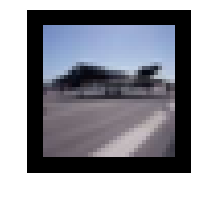

In [89]:
pad(xi(), 4, 'constant').show()

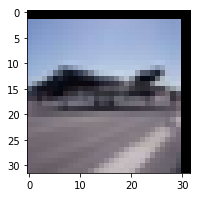

In [90]:
crop(pad(xi(), 4, 'constant'), 32, 0.25, 0.75).show(hide_axis=False)

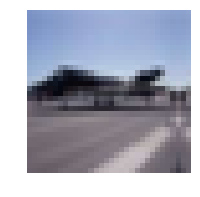

In [91]:
crop(pad(xi(), 4), 32, 0.25, 0.75).show()

## Combine

In [92]:
tfms = [flip_lr(p=0.5),
        pad(padding=4, mode='constant'),
        crop(size=32, row_pct=(0,1.), col_pct=(0,1.))]

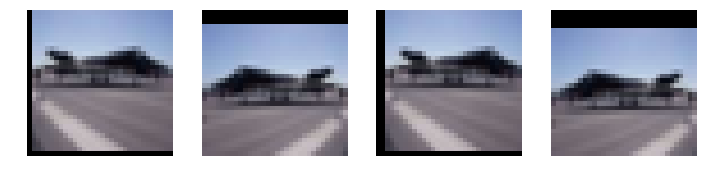

In [93]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms, x), ax)

In [94]:
tfms = [
    flip_lr(p=0.5),
    contrast(scale=(0.5,2.0)),
    brightness(change=(0.3,0.7)),
    rotate(degrees=(-45,45.), p=0.5),
    zoom(scale=(0.5,1.2), p=0.8)
]

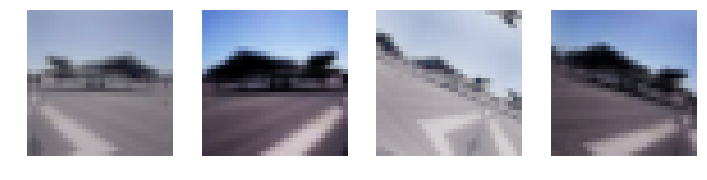

In [95]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_tfms(tfms, x), ax)

In [96]:
resize_image

Transform (resize_image)

In [97]:
_,axes = plt.subplots(2,4, figsize=(12,6))

for i in range(4):
    show_image(apply_tfms(tfms, x, padding_mode='zeros', xtra), axes[0][i], hide_axis=False)
    show_image(apply_tfms(tfms, x, mode='nearest', do_resolve=False), axes[1][i], hide_axis=False)

SyntaxError: positional argument follows keyword argument (<ipython-input-97-372a0ab7dbd2>, line 4)

## RandomResizedCrop (Torchvision version)

In [98]:
#export
def compute_zs_mat(sz, scale, squish, invert, row_pct, col_pct):
    orig_ratio = math.sqrt(sz[2]/sz[1])
    for s,r,i in zip(scale,squish, invert):
        s,r = math.sqrt(s),math.sqrt(r)
        if s * r <= 1 and s / r <= 1: #Test if we are completely inside the picture
            w,h = (s/r, s*r) if i else (s*r,s/r)
            w /= orig_ratio
            h *= orig_ratio
            col_c = (1-w) * (2*col_pct - 1)
            row_c = (1-h) * (2*row_pct - 1)
            return get_zoom_mat(w, h, col_c, row_c)
        
    #Fallback, hack to emulate a center crop without cropping anything yet.
    if orig_ratio > 1: return get_zoom_mat(1/orig_ratio**2, 1, 0, 0.)
    else:              return get_zoom_mat(1, orig_ratio**2, 0, 0.)

@TfmCoord
def zoom_squish(c, size, scale:uniform=1.0, squish:uniform=1.0, invert:rand_bool=False, 
                row_pct:uniform=0.5, col_pct:uniform=0.5):
    #This is intended for scale, squish and invert to be of size 10 (or whatever) so that the transform
    #can try a few zoom/squishes before falling back to center crop (like torchvision.RandomResizedCrop)
    m = compute_zs_mat(size, scale, squish, invert, row_pct, col_pct)
    return affine_mult(c, FloatTensor(m))

In [99]:
rrc = zoom_squish(scale=(0.25,1.0,10), squish=(0.5,1.0,10), invert=(0.5,10),
                                  row_pct=(0,1.), col_pct=(0,1.))

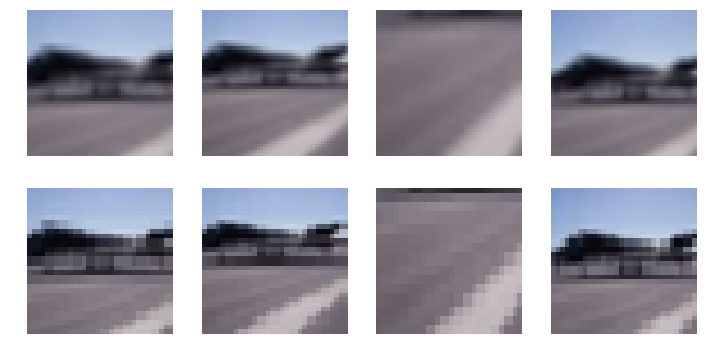

In [100]:
_,axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    show_image(apply_tfms(rrc, x, size=48), axes[0][i])
    show_image(apply_tfms(rrc, x, do_resolve=False, mode='nearest'), axes[1][i])